# Lasagne

In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T

import lasagne

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, batch_stream, onehot

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [7]:
y = onehot(y)

In [25]:
from lasagne import *

class NN(object):
    def __init__(self):
        X_batch = T.ftensor4('X_batch')
        y_batch = T.matrix('y_batch')
        
        input_l = layers.InputLayer(shape=(None, ) + X.shape[1:], input_var=X_batch)
        
        dense1 = layers.DenseLayer(
            input_l,
            num_units=32,
            nonlinearity=nonlinearities.sigmoid
        )
        
        dense2 = layers.DenseLayer(
            dense1,
            num_units=16,
            nonlinearity=nonlinearities.sigmoid
        )
        
        dense3 = layers.DenseLayer(
            dense2,
            num_units=10,
            nonlinearity=nonlinearities.softmax
        )
        self.net = dense3
        
        prediction = layers.get_output(dense3)
        
        reg = regularization.regularize_network_params(
            dense3,
            regularization.l2
        )

        log_loss = T.mean(objectives.categorical_crossentropy(prediction, y_batch))
        
        c_regularization = T.fscalar('C_regularization')
        
        loss = log_loss + c_regularization * reg
        
        learning_rate = T.fscalar('float32')
        upd = updates.adadelta(loss, layers.get_all_params(dense3), learning_rate=learning_rate)
        
        self.train = theano.function(
            [X_batch, y_batch, c_regularization, learning_rate],
            log_loss,
            updates=upd
        )

        self.predict = theano.function([X_batch], prediction)

    def fit(self, X, y, c_reg = 1.0e-3, learning_rate=1.0, n_epoches=1, batch_size=32, watcher=None):
        history = np.zeros(shape=(n_epoches, X.shape[0] / batch_size))
        
        for epoch in xrange(n_epoches):
            for i, (X_batch, y_batch) in enumerate(batch_stream([X, y], batch_size=batch_size)):
                history[epoch, i] = self.train(X_batch, y_batch, c_reg, learning_rate)
            
            if watcher is not None:
                watcher.draw(history[:(epoch + 1)])

In [26]:
nn = NN()

<IPython.core.display.Javascript object>


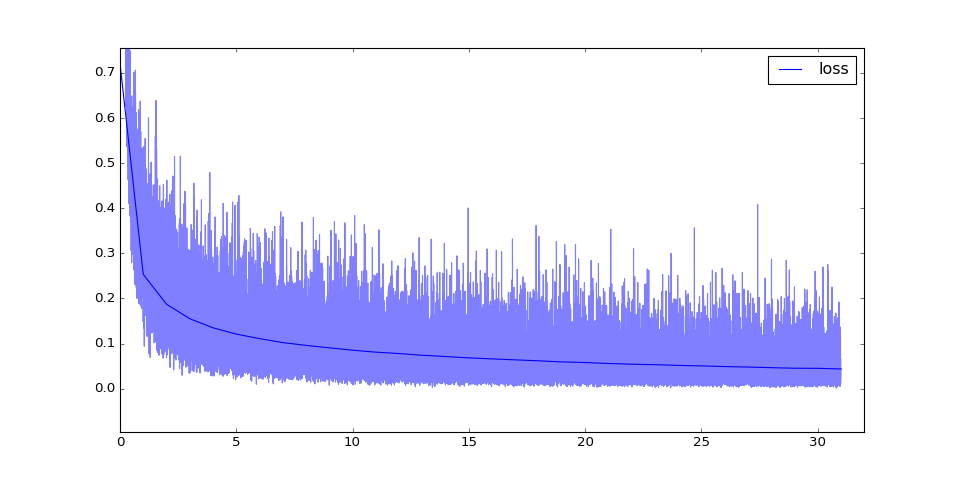

In [27]:
watcher = NNWatcher()

In [28]:
nn.fit(X, y, c_reg = 1.0e-5, learning_rate=1.0, n_epoches=32, batch_size=64, watcher=watcher)

In [29]:
predicted = np.argmax(nn.predict(X_test), axis=1)

In [30]:
np.mean(predicted == y_test)

0.96660000000000001

In [34]:
W1, _, W2, _, W3, _ = [param.get_value() for param in layers.get_all_params(nn.net)]

In [35]:
W1 = W1.reshape(28, 28, -1)

<IPython.core.display.Javascript object>


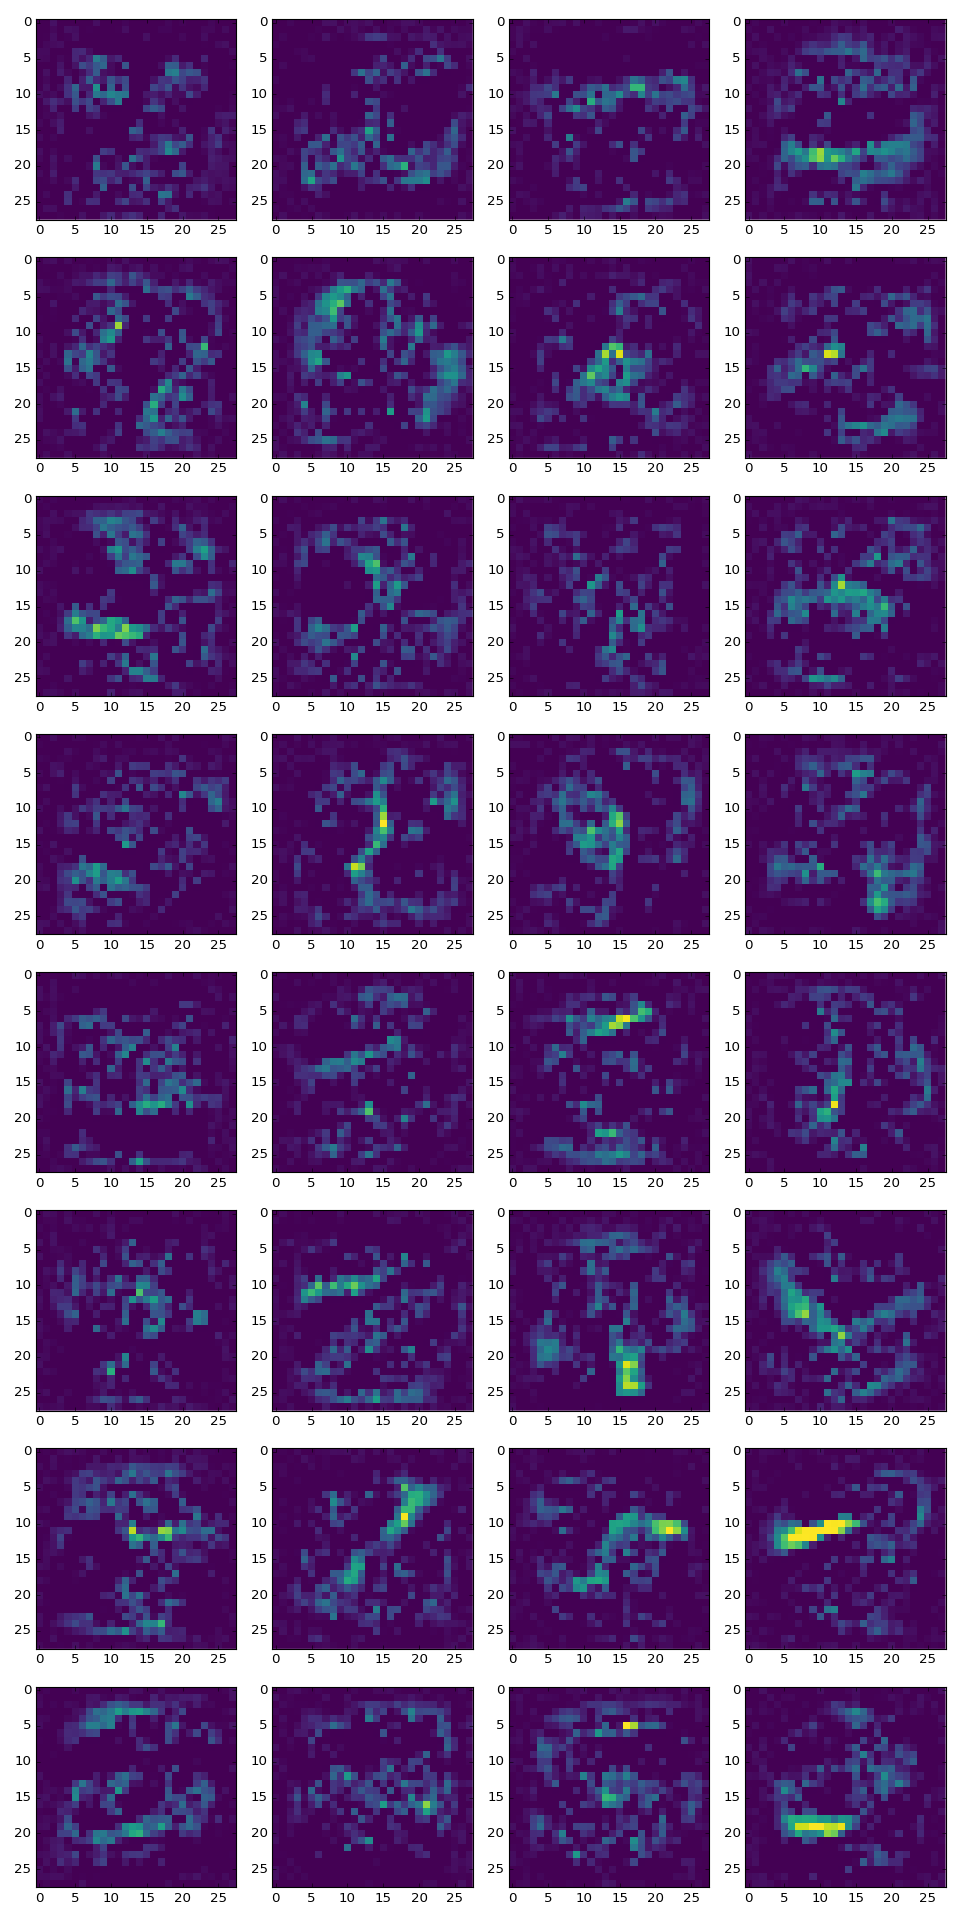

In [37]:
import itertools

nrows = 8
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 3 , nrows * 3))

for i, j in itertools.product(range(nrows), range(ncols)):
    k = i * ncols + j

    ax[i, j].imshow(
        W1[:, :, k],
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=1.0
    )

#fig.suptitle('Visualization of the first hidden coefficients')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


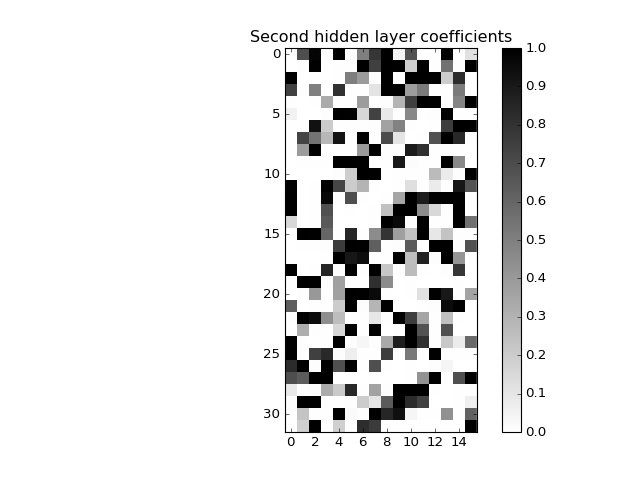

In [39]:
plt.figure()
plt.imshow(W2, interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.title('Second hidden layer coefficients')

<IPython.core.display.Javascript object>


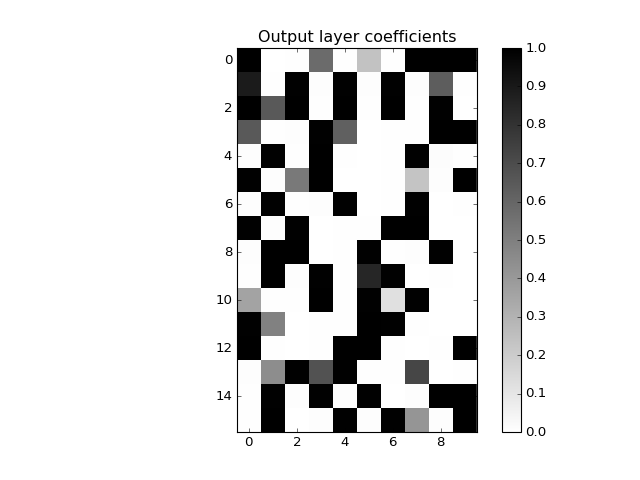

In [41]:
plt.figure()
plt.imshow(W3, interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.title('Output layer coefficients')